In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib.offsetbox import AnchoredText
from coffea.util import load
from coffea.hist import plot
from coffea import hist
def optimize(hist_s,hist_b, ch='emu',r='SR',log=True, name='DeepJet', target="Z",  debug=True, save=None,
             label_kw={'year': 2017, 'label': 'Preliminary'}, weird=False):

    if ch=='ll':
        sig = hist_s.integrate('lepflav','ee').integrate('flav',slice(4,5)).sum('dataset').sum('region').values()[()]+hist_s.integrate('lepflav','mumu').integrate('flav',slice(4,5)).sum('dataset').sum('region').values()[()]   

        bkg = [
                hist_s.integrate('lepflav','ee').integrate('flav',slice(0,4)).sum('dataset').sum('region').values()[()],
                hist_s.integrate('lepflav','ee').integrate('flav',slice(5,6)).sum('dataset').sum('region').values()[()],
                hist_b.integrate('lepflav','ee').sum('flav').sum('dataset').sum('region').values()[()],
            hist_s.integrate('lepflav','mumu').integrate('flav',slice(0,4)).sum('dataset').sum('region').values()[()],
                hist_s.integrate('lepflav','mumu').integrate('flav',slice(5,6)).sum('dataset').sum('region').values()[()],
                hist_b.integrate('lepflav','mumu').sum('flav').sum('dataset').sum('region').values()[()],
            ]
    else:
        sig = hist_s.integrate('lepflav',ch).integrate('flav',slice(4,5)).sum('dataset').sum('region').values()[()]   

        bkg = [
                hist_s.integrate('lepflav',ch).integrate('flav',slice(0,4)).sum('dataset').sum('region').values()[()],
                hist_s.integrate('lepflav',ch).integrate('flav',slice(5,6)).sum('dataset').sum('region').values()[()],
                hist_b.integrate('lepflav',ch).sum('flav').sum('dataset').sum('region').values()[()],
            ]
    bkg = np.sum(bkg, axis=0)
   
    if ch=='ll':    
        xbins = hist_s.integrate('lepflav','ee').integrate('flav',slice(0,4)).sum('dataset').sum('region').to_hist().axes['btagDeepFlavCvL'].edges
        ybins = hist_s.integrate('lepflav','ee').integrate('flav',slice(0,4)).sum('dataset').sum('region').to_hist().axes['btagDeepFlavCvB'].edges
    else:
        xbins = hist_s.integrate('lepflav',ch).integrate('flav',slice(0,4)).sum('dataset').sum('region').to_hist().axes['btagDeepFlavCvL'].edges
        ybins = hist_s.integrate('lepflav',ch).integrate('flav',slice(0,4)).sum('dataset').sum('region').to_hist().axes['btagDeepFlavCvB'].edges
    
    if debug:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
        plt.sca(ax1)
        hep.histplot(np.sum(sig, axis=0), bins=xbins, label="Signal", binwnorm=np.sum(bkg, axis=None))
        hep.histplot(np.sum(bkg, axis=0), bins=xbins, label="Background", binwnorm=np.sum(sig, axis=None))
        plt.sca(ax2)
        hep.histplot(np.sum(sig, axis=1), bins=ybins, label="Signal", binwnorm=np.sum(bkg, axis=None))
        hep.histplot(np.sum(bkg, axis=1), bins=ybins, label="Background", binwnorm=np.sum(sig, axis=None))
        ax1.semilogy()
        ax2.semilogy()
        ax1.legend()
        ax2.legend()
        
        ax1.set_xlabel(f"{name} CvB")
        ax2.set_xlabel(f"{name} CvL")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
        hep.hist2dplot(np.log(sig[1:, :]), cbar=False, ax=ax1, xbins=xbins[1:], ybins=ybins)
        hep.hist2dplot(np.log(bkg[1:, :]), cbar=False, ax=ax2, xbins=xbins[1:], ybins=ybins)
        ax1.set_title("Signal")
        ax2.set_title("Background")
        for ax in [ax1, ax2]:
#             ax.semilogx()
            ax.set_xlabel(f"{name} CvL")
            ax.set_ylabel(f"{name} CvB")   
        
    xsize = len(xbins)-1
    rat = np.zeros((xsize, xsize))
    for cvl in np.arange(0, xsize):
        for cvb in np.arange(0, xsize):
              rat[cvl, cvb] = np.sum(sig[cvl:, cvb:])/np.sum(bkg[cvl:, cvb:])
                #np.sqrt(np.sum(bkg[cvl:, cvb:])+np.sum(sig[cvl:, cvb:]))
    
    fig, ax = plt.subplots()
    def _adjust(bins):
        return bins[:-1]
    hep.hist2dplot(rat, xbins, ybins)
    xy = np.meshgrid(_adjust(xbins), _adjust(ybins))
    CS = ax.contour(xy[0], xy[1], rat.T, colors='white', levels=10)
    if target == "H":
        ax.clabel(CS, inline=1, fontsize=20, fmt='%1.3f');
    else:
        ax.clabel(CS, inline=1, fontsize=20, fmt='%1.3f');
    x, y = np.where(rat==np.nanmax(rat[np.isfinite(rat)]))
    ax.hlines(ybins[y][0], 0, 1, color='red', lw=2)
    ax.vlines(xbins[x][0], 0, 1, color='red', lw=2)
    print(ybins[y][0],xbins[x][0])
    ax.set_xlabel(f"{name} CvL")
    ax.set_ylabel(f"{name} CvB")
    fig.get_children()[-1].set_ylabel("$S/\mathrm{\sqrt{B}}$");
#     if log:
#         plt.xlim(0.01, None)
# #         plt.semilogx()
#         plt.ylim(0.001, None)
# #         plt.semilogy()
    
#     ax.scatter(0.5, 0.2, marker='*', color='red', s=100)
    
#     from matplotlib.offsetbox import AnchoredText
    if r=='SR':reg='nj>1'
    else : reg="nj==1"
    if ch =='ll':ch='$\ell\ell$'
    else : ch = '$e\mu$'
#     at = AnchoredText(f"channel: {ch} reg:{reg}", loc='upper right', frameon=False, prop=dict(linespacing=1.5, fontsize=18))
#     string="%s %s" %(ch,reg)
#     plt.text(0.2,1.05,string,fontsize=14)
#     plt.gca().add_artist(at)
    
    ax.text(xbins[x]*0.9, ybins[y]*0.9, "{:.3f}".format(np.nanmax(rat[np.isfinite(rat)])), 
            ha='right', va='top', color='red', fontsize='small')
    
#     transx = transforms.blended_transform_factory(ax.transData, ax.transAxes)
#     ax.text(xbins[x] * 0.95, 0.02, "{:.3f}".format(xbins[x][0]), 
#             ha='right', va='bottom', color='black', fontsize='x-small', transform=transx)
    
#     transx = transforms.blended_transform_factory(ax.transAxes, ax.transData)
#     ax.text(0.02, ybins[y] * 0.95, "{:.3f}".format(ybins[y][0]), 
#             ha='left', va='top', color='black', fontsize='x-small', transform=transx)
    
#     hep.cms.label(**label_kw)
    
    if save:
        name = f"opt_{target}_DDX_{region}_{year}"
        saveall(ax, savedir='plots', subdir="sig_opt", plotname=name) 
    else:
        return fig


/eos/user/m/milee/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
/eos/user/m/milee/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log
/eos/user/m/milee/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
/eos/user/m/milee/miniconda3/envs/coffea/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


0.94 0.9


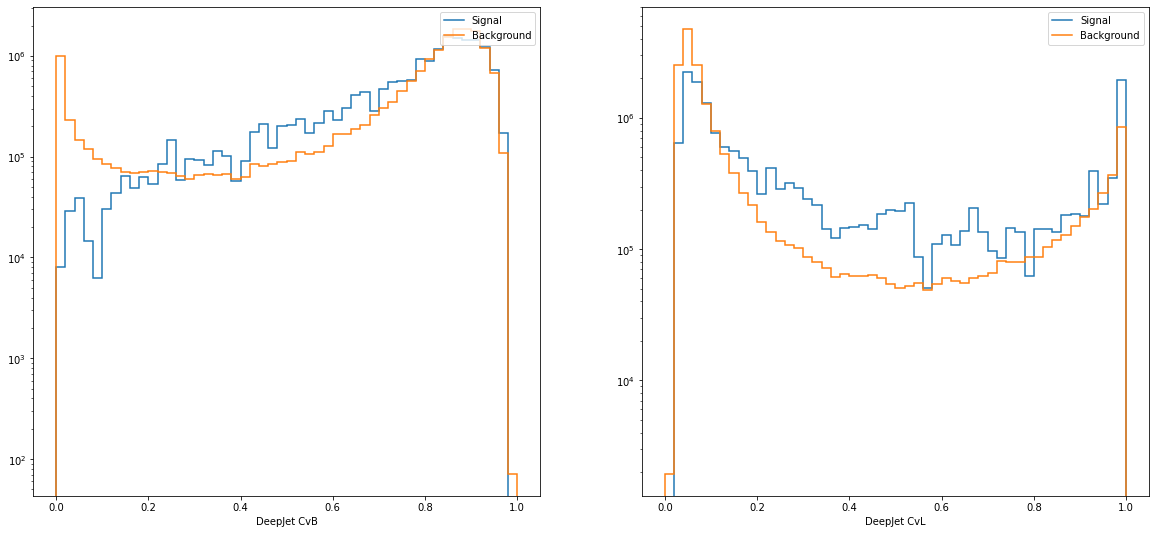

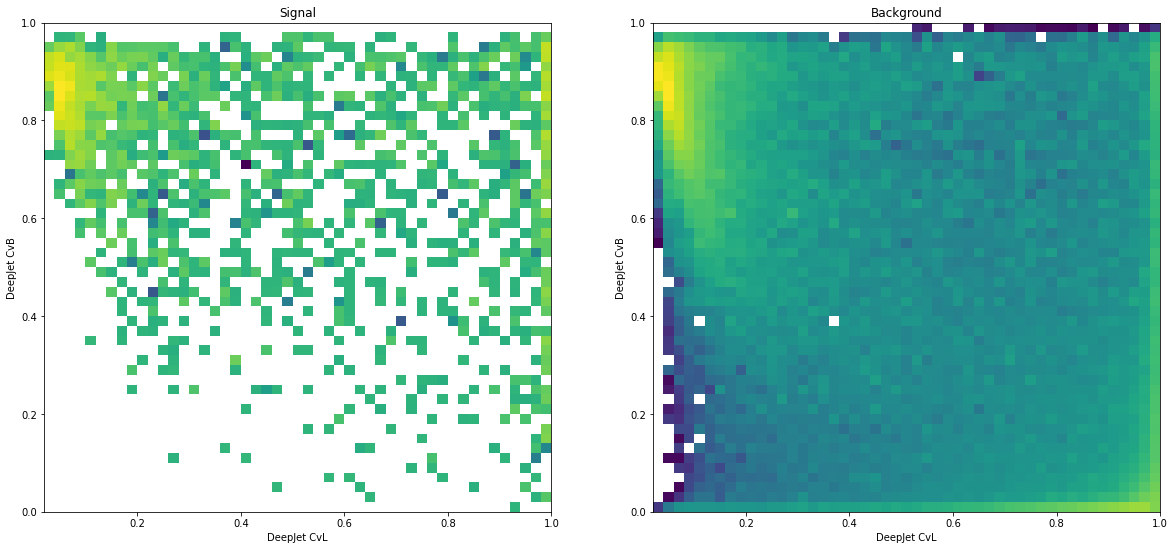

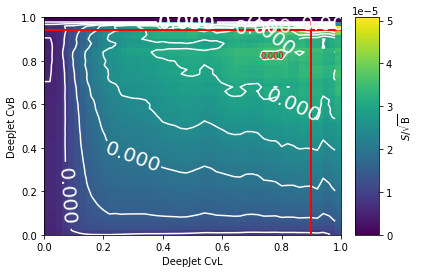

In [19]:
from utils.xs_scaler import scale_xs

outputb=load('hists_HWW2l2nutest_mcbkg_UL172Dup.coffea')
# outputs=load('hists_HWW2l2nutest_signal_UL17.coffea')
outputs=load('hists_HWW2l2nutest_signal_UL17test2d.coffea')
histsig=outputs['DeepJet2D']
histbkg=outputb['DeepJet2D']
histsig=scale_xs(histsig,41500,outputs['sumw'])
histbkg=scale_xs(histbkg,41500,outputb['sumw'])
histsig= histsig.rebin("btagDeepFlavCvL", hist.Bin("btagDeepFlavCvL", "DeepJet CvL", 50,0,1))
histsig= histsig.rebin("btagDeepFlavCvB", hist.Bin("btagDeepFlavCvB", "DeepJet CvB", 50,0,1))
histbkg= histbkg.rebin("btagDeepFlavCvL", hist.Bin("btagDeepFlavCvL", "DeepJet CvL", 50,0,1))
histbkg= histbkg.rebin("btagDeepFlavCvB", hist.Bin("btagDeepFlavCvB", "DeepJet CvB", 50,0,1))
# fig = optimize(histsig,histbkg, name='DeepJet', ch='ee', log=True, debug=True, weird=True,save=False);
# fig = optimize(histsig,histbkg, name='DeepJet', ch='ee', log=False, debug=True, weird=True,save=False);
# fig2 = optimize(histsig,histbkg, name='DeepJet', ch='mumu', log=False, debug=True, weird=True,save=False);
# fig3 = optimize(histsig,histbkg, name='DeepJet',r='SR2', ch='emu', log=False, debug=True, weird=True,save=False);
fig4 = optimize(histsig,histbkg, name='DeepJet',r='SR2', ch='ll', log=False, debug=True, weird=True,save=False);
# fig5 = optimize(histsig,histbkg, name='DeepJet',r='SR2', ch='emu', log=False, debug=True, weird=True,save=False);
# fig5.savefig('/eos/user/m/milee/www/plots/emu_2Dopt.png')
# fig4.savefig('/eos/user/m/milee/www/plots/ll_2Dopt.png')

<AxesSubplot:xlabel='btagDeepFlavCvB', ylabel='Counts'>

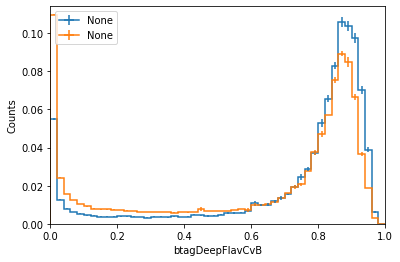

In [22]:
# outputb=load('hists_HWW2l2nutest_mcbkg_UL172D.coffea')
outputs=load('hists_HWW2l2nutest_mcbkg_UL172Dup.coffea')
# outputs2=load('hists_HWW2l2nutest_signal_UL17test.coffea')

histsig=outputs['DeepJet2D']
# histsig2=outputs2['DeepJet2D']
histsig=scale_xs(histsig,41500,outputs['sumw'])
# histsig2=scale_xs(histsig2,41500,outputs2['sumw'])
fig,ax = plt.subplots()
ax = plot.plot1d(histsig.integrate('lepflav','ee').integrate('flav').sum('dataset').sum('region').sum('btagDeepFlavCvL'),density=True)
plot.plot1d(histsig.integrate('lepflav','emu').integrate('flav').sum('dataset').sum('region').sum('btagDeepFlavCvL'),density=True,clear=False)
# plot.plot1d(histsig2.integrate('lepflav','ee').integrate('flav',slice(4,5)).sum('dataset').sum('region').sum('btagDeepFlavCvL'),clear=False,density=True,ax=ax)

# fig2,ax2 = plt.subplots()
# ax2 = plot.plot1d(histsig.integrate('lepflav','ee').integrate('flav',slice(4,5)).sum('dataset').sum('region').sum('btagDeepFlavCvB'),ax=ax2,density=True)
# plot.plot1d(histsig2.integrate('lepflav','ee').integrate('flav',slice(4,5)).sum('dataset').sum('region').sum('btagDeepFlavCvB'),clear=False,ax=ax2,density=True)